## Connecting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Importing Libraries

In [2]:
import numpy as np
import seaborn as sns
import keras, os, cv2, imghdr
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

from keras.models import Model
from tensorflow.keras import optimizers , layers
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.python.ops import array_ops

### Dataset Path

In [6]:
data_dir = '/content/drive/MyDrive/data_3k'  # Change this to your dataset path

## Images Verification

In [7]:
def check_images(s_dir, ext_list):
    bad_images = []
    bad_ext = []
    s_list = os.listdir(s_dir)
    for klass in s_list:
        klass_path = os.path.join(s_dir, klass)
        print('Processing class directory:', klass)
        if os.path.isdir(klass_path):
            file_list = os.listdir(klass_path)
            for f in file_list:
                f_path = os.path.join(klass_path, f)
                tip = imghdr.what(f_path)
                if tip not in ext_list:
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img = cv2.imread(f_path)
                        if img is None:
                            raise ValueError("Image read failed")
                        shape = img.shape  # Check image shape to confirm it's readable
                    except Exception as e:
                        print(f'File {f_path} is not a valid image file:', e)
                        bad_images.append(f_path)
                else:
                    print(f'*** Fatal error: You have a subdirectory {f} in class directory {klass}')
        else:
            print(f'*** WARNING ***: You have files in {s_dir} that should only contain subdirectories')
    return bad_images, bad_ext

source_dir =  data_dir
good_exts = ['jpg', 'jpeg', 'png', 'gif', 'bmp']  # List of acceptable extensions
bad_file_list, bad_ext_list = check_images(source_dir, good_exts)

if bad_file_list or bad_ext_list:
    print('Improper image files are listed below:')
    for file in bad_file_list:
        print('Invalid image:', file)
    for file in bad_ext_list:
        print('Invalid extension:', file)
else:
    print('No improper image files were found.')


Processing class directory: VeryMildDemented
Processing class directory: MildDemented
Processing class directory: NonDemented
Processing class directory: ModerateDemented
No improper image files were found.


## Data Splitting

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(227, 227),
  batch_size=32)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=1,
  image_size=(227, 227),
  batch_size=32)

for x, y in train_ds.take(1):
  print('Image --> ', x.shape, 'Label --> ',  y.shape)

Found 12000 files belonging to 4 classes.
Using 8400 files for training.
Found 12000 files belonging to 4 classes.
Using 3600 files for validation.
Image -->  (32, 227, 227, 3) Label -->  (32,)


In [9]:
class_names = train_ds.class_names
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

## Getting Batch of Data

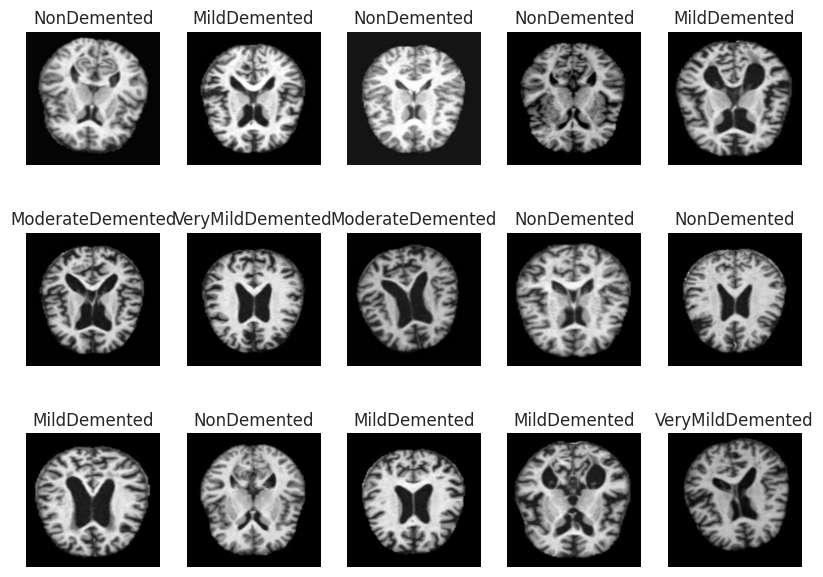

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Model Implementation

In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.96435374


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)

    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)

    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)




In [15]:
model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [16]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


263/263 ━━━━━━━━━━━━━━━━━━━━ 116s 362ms/step - accuracy: 0.2869 - loss: 2.9040 - val_accuracy: 0.3936 - val_loss: 1.3169
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 48s 68ms/step - accuracy: 0.3159 - loss: 2.4012 - val_accuracy: 0.4883 - val_loss: 1.1689
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.3833 - loss: 1.9887 - val_accuracy: 0.5297 - val_loss: 1.0788
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.4003 - loss: 1.8090 - val_accuracy: 0.5544 - val_loss: 1.0202
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.4359 - loss: 1.6476 - val_accuracy: 0.5892 - val_loss: 0.9531
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.4440 - loss: 1.5244 - val_accuracy: 0.6053 - val_loss: 0.9233
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.4834 - loss: 1.4013 - val_accuracy: 0.6272 - val_loss: 0.8820
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.5115 - loss: 1.2866 - val_accur

In [40]:
model.save('/content/drive/MyDrive/alex_net.h5')

## Training and Validation Loss Accuracy Graph

In [ ]:
sns.set_style("darkgrid")

def plot_history(model_history):
    train_acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    x = range(1, len(train_acc) + 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, train_acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig("figure.jpg")
    plt.show()


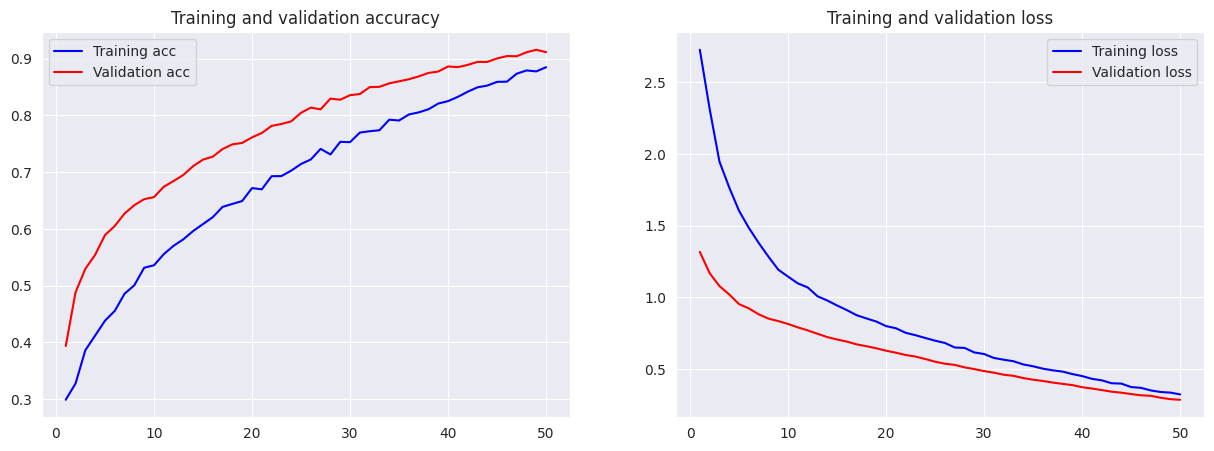

In [17]:
plot_history(history)

In [18]:
loss, accuracy = model.evaluate(val_ds, batch_size=32)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9170 - loss: 0.2758
Test: accuracy = 0.911667  ;  loss = 0.286095 


In [19]:
yp_train = model.predict(train_ds)
yp_train = np.argmax(yp_train, axis=-1)
print(yp_train)

263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
[1 0 3 ... 3 0 0]


In [20]:
true_categories = tf.concat([y for x, y in train_ds], axis=0)

## Classification Report

In [21]:
classification_report(true_categories,yp_train)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2128
           1       0.99      1.00      0.99      2095
           2       0.97      0.95      0.96      2101
           3       0.97      0.95      0.96      2076

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



## Confusion Matrix

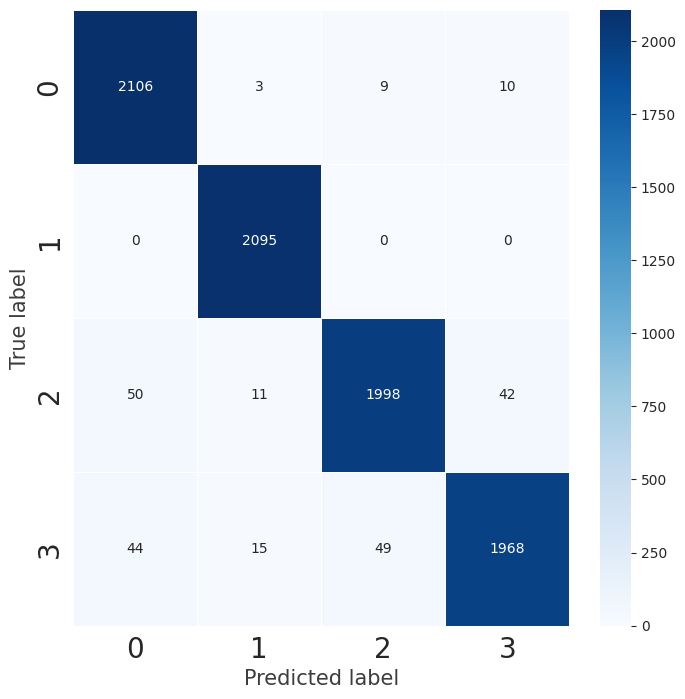

In [22]:
cm = confusion_matrix(true_categories,yp_train)

f, ax = plt.subplots(figsize =(8,8))
ax.tick_params(labelsize=20)
sns.heatmap(cm,annot = True,linewidths=0.5,fmt = ".0f",ax=ax ,cmap='Blues')
plt.ylabel('True label',fontsize=15,color="#3d3d3d")
plt.xlabel('Predicted label',fontsize=15,color="#3d3d3d")
# plt.savefig("training_confusion_matrix.jpg")
plt.show()

## Accuracy

In [29]:
class_accuracy = 100 * np.diag(cm) / np.sum(cm, axis=1)

for i, class_name in enumerate(class_names):
    print(f'Accuracy of {class_name}: {class_accuracy[i]:.2f}%')

Accuracy of MildDemented: 98.97%
Accuracy of ModerateDemented: 100.00%
Accuracy of NonDemented: 95.10%
Accuracy of VeryMildDemented: 94.80%


In [39]:
true_categories_cpu = true_categories.cpu().numpy()
print(f"Accuracy: {accuracy_score(true_categories_cpu, yp_train):.4f}")

Accuracy: 0.9723


In [41]:
from tensorflow.keras.models import load_model

# Load the model from Google Drive
loaded_model = load_model('/content/drive/MyDrive/alex_net.h5')

# Check the loaded model summary
loaded_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │          16,3

 Total params: 58,303,238 (222.41 MB)

 Trainable params: 58,300,484 (222.40 MB)

 Non-trainable params: 2,752 (10.75 KB)

 Optimizer params: 2 (12.00 B)

In [55]:
IMAGE_SIZE = (227, 227) # Ensure this matches the image size used during training

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/alex_net.h5') # Replace with your model path

In [56]:
def predict_image(test_image_path):
  test_image = cv2.imread(test_image_path)
  test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

  # Preprocess the test image
  test_image = cv2.resize(test_image, IMAGE_SIZE)
  test_image = test_image / 255.0  # Normalize pixel values

  # Reshape the image to match the expected input shape of the model
  test_image = np.expand_dims(test_image, axis=0)

  # Make predictions on the test image
  predicted_probabilities = loaded_model.predict(test_image)

  # Get the predicted class label
  predicted_class_index = np.argmax(predicted_probabilities)
  predicted_class_name = class_names[predicted_class_index]

  # Display the test image and predicted class label
  plt.imshow(test_image.squeeze())
  plt.title(f'Predicted Class: {predicted_class_name}')
  plt.axis('off')
  plt.show()

### Testing VeryMild Class

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


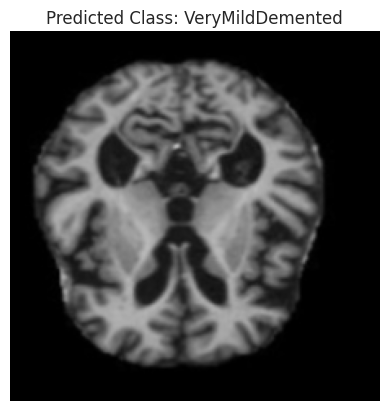

In [57]:
test_image_path = '/content/drive/MyDrive/data_3k/VeryMildDemented/47857804-75e9-4d0a-b2b3-ada2c59c3b0c.jpg'  # Replace with the path to your test image
predict_image(test_image_path)